In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import talib
import functions
from backtesting import Backtest, Strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
_df = functions.get_data('2454.TW', '2017-05-25', '2022-05-26')
_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock splits,Foreign,Trust,Dealer,Total
Date,,,,,,,,,,,
2017-05-25,192.774853,197.926965,189.769455,196.209595,23568000,0.0,0,8029,286,884,9199
2017-05-26,197.068283,198.356311,195.350912,197.068283,12758000,0.0,0,3698,659,-1264,3093
2017-05-31,197.497635,199.215006,196.638950,197.497635,11672000,0.0,0,1618,108,-194,1532
2017-06-01,197.497629,198.356314,195.350916,195.780258,5294000,0.0,0,315,0,-213,102
2017-06-02,197.497647,202.649759,197.068304,200.932388,11260000,0.0,0,1989,126,1543,3658


In [3]:
chip_df = functions.chip_signal(_df.copy())

### RSI w/ EMA

In [4]:
class RSI_EMA(Strategy):
    
    n1 = 20
    n2 = 50
    n3 = 5
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        
        ema1 = talib.EMA(close, timeperiod=self.n1)
        ema2 = talib.EMA(close, timeperiod=self.n2)
        rsi = talib.RSI(close, timeperiod=self.n3)
        
        # compute buy and sell signals (golden cross and death cross)
        signal_long = (rsi.shift() < 30) & (ema1 > ema2)
        signal_short = (rsi.shift() > 70) & (ema1 < ema2)
        
        # combine long and short signals
        signal = signal_long
        signal[signal_short] = -1
        
        # combine chip signal
        self.chip_signal(signal)
        
        # plot sma
        self.I(lambda x: ema1, 'ema1')
        self.I(lambda x: ema2, 'ema2')
        self.I(lambda x: rsi, 'RSI')
        
        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')
        
    def chip_signal(self, signal):
        return signal
        
    def next(self):
        super().next()
        
        entry_size = self.signal[-1]
        price = self.data.Close[-1]
        
        # long/short SL and TP
        long_sl = price * 0.85
        long_tp = price * 1.15
        short_sl = price * 1.15
        short_tp = price * 0.85
        
        if entry_size > 0: 
            self.buy()
        elif entry_size < 0: 
            for trade in self.trades:
                trade.close()
                
        """
        if entry_size > 0:
            self.buy(size = 0.3, sl = long_sl, tp = long_tp)
        elif entry_size < 0:
            # sell all
            for trade in self.trades:
                trade.close()
            self.sell(size = 0.3, sl = short_sl, tp = short_tp)
        """

In [5]:
class RSI_EMA_chip(RSI_EMA):
    # override 'chip_signal' function
    def chip_signal(self, signal):
        chip_signal = pd.Series(self.data.ChipSignal)
        
        for i in range(len(chip_signal)):
            if chip_signal[i] == 1:
                signal[i] = 1
            elif chip_signal[i] == -1:
                signal[i] = -1
        
        return signal

In [6]:
bt_rsi_ema = Backtest(_df, RSI_EMA, cash=100000, commission=0.001425, trade_on_close=True)
result_rsi_ema = bt_rsi_ema.run(n1=20, n2=50, n3=5)
bt_rsi_ema.plot()

Row(id='1586', ...)

<AxesSubplot:>

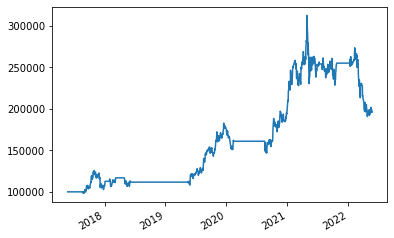

In [7]:
result_rsi_ema._equity_curve.Equity.plot()

In [8]:
result_rsi_ema_opt = bt_rsi_ema.optimize(n1=range(5, 200, 5),
                                         n2=range(5, 200, 5))
result_rsi_ema_opt._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1521 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/11 [00:00<?, ?it/s]

<Strategy RSI_EMA(n1=10,n2=25)>

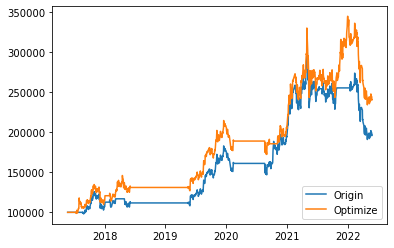

In [9]:
plt.figure()
plt.plot(result_rsi_ema._equity_curve.Equity, label='Origin')
plt.plot(result_rsi_ema_opt._equity_curve.Equity, label='Optimize')
plt.legend(loc='lower right')
plt.show()

### Chip Analysis

In [13]:
bt_rsi_ema_chip = Backtest(chip_df, RSI_EMA_chip, cash=100000, commission=0.001425, trade_on_close=True)
result_rsi_ema_chip = bt_rsi_ema_chip.run(n1=5, n2=20, n3=5)
bt_rsi_ema_chip.plot()

Row(id='3538', ...)

In [11]:
result_rsi_ema_chip = bt_rsi_ema_chip.optimize(n1=range(5, 200, 5),
                                               n2=range(5, 200, 5))
result_rsi_ema_chip._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1521 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/11 [00:00<?, ?it/s]

<Strategy RSI_EMA_chip(n1=5,n2=20)>

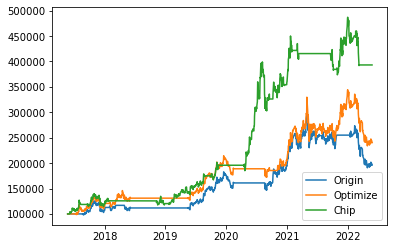

In [12]:
plt.figure()
plt.plot(result_rsi_ema._equity_curve.Equity, label='Origin')
plt.plot(result_rsi_ema_opt._equity_curve.Equity, label='Optimize')
plt.plot(result_rsi_ema_chip._equity_curve.Equity, label='Chip')
plt.legend(loc='lower right')
plt.show()